## TEAM TRENDS <a id="team-trends"></a>

### General <a id="team-general"></a>

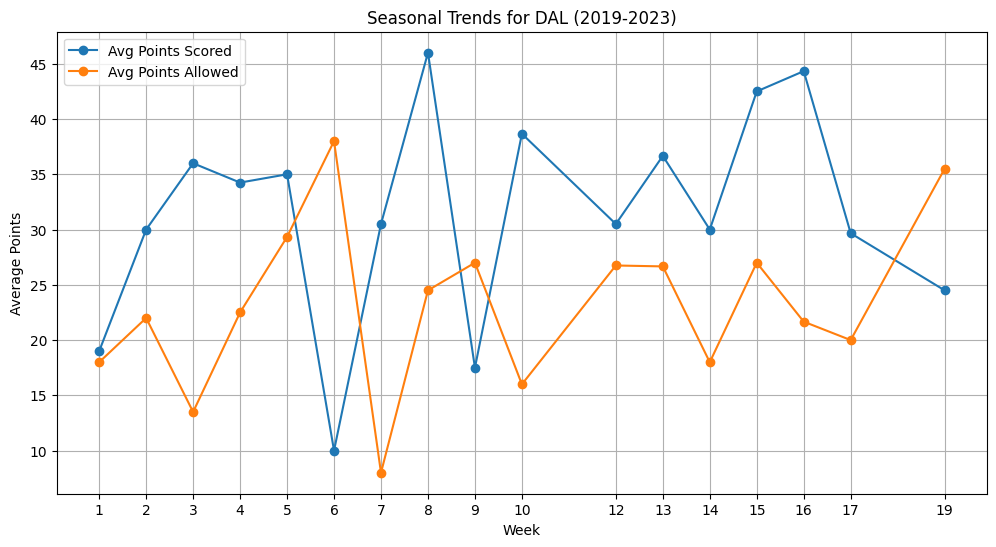

In [30]:
# Analyzing Seasonal Trends in Average Points Scored and Allowed by NFL Teams (2019-2023)

team = 'DAL'  # Example team

# Load the dataset
df = pd.read_csv('data/Games.csv')

# Filter for recent seasons if needed (e.g., 2019-2023)
df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])]

# Group by team and week to calculate average points scored and allowed per week
team_weekly_performance = df_recent.groupby(['home_team', 'week']).agg(
    avg_points_scored=('home_score', 'mean'),
    avg_points_allowed=('away_score', 'mean')
).reset_index()

# Plotting seasonal trends for a selected team (e.g., DAL)
team_data = team_weekly_performance[team_weekly_performance['home_team'] == team]

plt.figure(figsize=(12, 6))
plt.plot(team_data['week'], team_data['avg_points_scored'], label='Avg Points Scored', marker='o')
plt.plot(team_data['week'], team_data['avg_points_allowed'], label='Avg Points Allowed', marker='o')
plt.title(f'Seasonal Trends for {team} (2019-2023)')
plt.xlabel('Week')
plt.ylabel('Average Points')
plt.xticks(team_data['week'])
plt.grid(True)
plt.legend()
plt.show()

### Defense <a id="defense"></a>

In [6]:
# Loop and rank all teams 2020-2024 seasons

# Function to calculate total defensive yards allowed for a given team and season
def calculate_team_total_yards_defensive_stats(team_abbreviation, season, data_df):
    # Filter for the specified season by extracting the season from the 'game_id' column
    data_df['season'] = data_df['game_id'].str.slice(0, 4).astype(int)

    # # Filter the data for the specific season
    # if season == 2024:
    #     # For the current season, only consider games played so far
    #     current_week = data_df[data_df['season'] == season]['game_id'].str.slice(5, 7).astype(int).max()  # Get the latest week
    #     season_games = data_df[(data_df['season'] == season) & (data_df['game_id'].str.slice(5, 7).astype(int) <= current_week)]
    # else:
    #     season_games = data_df[data_df['season'] == season]
    # Filter the data for the specific season
    if season == 2024:
        # Filter out unplayed games based on the key stats columns (assuming unplayed games have all zeros)
        season_games = data_df[(data_df['season'] == season) &
                               (data_df[['away_rush_yds', 'away_pass_yds', 'home_rush_yds', 'home_pass_yds']].sum(axis=1) > 0)]
    else:
        season_games = data_df[data_df['season'] == season]


    # Initialize lists for away and home games
    away_games = []
    home_games = []

    # Loop through each game and split game_id to determine home/away status
    for index, row in season_games.iterrows():
        game_id_parts = row['game_id'].split('_')
        game_season, week, away_team, home_team = game_id_parts

        # Convert the week to an integer to filter weeks 01-18
        week_num = int(week)

        if week_num > 18:
            continue  # Skip postseason weeks

        if away_team == team_abbreviation:
            away_games.append(row)  # The team was the away team in this game
        elif home_team == team_abbreviation:
            home_games.append(row)  # The team was the home team in this game

    # Convert lists to DataFrames for easier processing
    away_games_df = pd.DataFrame(away_games)
    home_games_df = pd.DataFrame(home_games)

    # Convert lists to DataFrames for easier processing
    away_games_df = pd.DataFrame(away_games)
    home_games_df = pd.DataFrame(home_games)

    if not away_games_df.empty and all(col in away_games_df for col in ['home_rush_yds', 'home_pass_yds']):
        away_defense_stats = away_games_df[['home_rush_yds', 'home_pass_yds']].sum()
    else:
        away_defense_stats = pd.Series({'home_rush_yds': 0, 'home_pass_yds': 0})
    
    if not home_games_df.empty and all(col in home_games_df for col in ['away_rush_yds', 'away_pass_yds']):
        home_defense_stats = home_games_df[['away_rush_yds', 'away_pass_yds']].sum()
    else:
        home_defense_stats = pd.Series({'away_rush_yds': 0, 'away_pass_yds': 0})

    # # For home games, we want the stats from the "away" columns (opponent is away team)
    # home_defense_stats = home_games_df[['away_rush_yds', 'away_pass_yds']].sum()

    # # For away games, we want the stats from the "home" columns (opponent is home team)
    # away_defense_stats = away_games_df[['home_rush_yds', 'home_pass_yds']].sum()

    # Combine rushing and passing yards for all games
    total_rush_yards_allowed = home_defense_stats['away_rush_yds'] + away_defense_stats['home_rush_yds']
    total_pass_yards_allowed = home_defense_stats['away_pass_yds'] + away_defense_stats['home_pass_yds']

    # Calculate total yards allowed (rushing + passing)
    total_yards_allowed = total_rush_yards_allowed + total_pass_yards_allowed

    # Number of games played by the team
    num_games = len(home_games_df) + len(away_games_df)

    # Calculate averages for total yards allowed
    defensive_summary = {
        "avg_total_yards_allowed": total_yards_allowed / num_games if num_games > 0 else 0,
        "avg_rush_yards_allowed": total_rush_yards_allowed / num_games if num_games > 0 else 0,
        "avg_pass_yards_allowed": total_pass_yards_allowed / num_games if num_games > 0 else 0,
        "season": season
    }

    return defensive_summary

# Load the dataset (assuming it's located in 'data/' folder)
file_path = 'data/all_team_game_logs.csv'
team_game_logs_df = pd.read_csv(file_path)

# List of all team abbreviations
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 
         'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 
         'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# List to hold defensive stats for all teams
defensive_stats_list = []

# Loop through the seasons 2020 to 2023, and the played games in 2024
for season in range(2020, 2025):
    for team in teams:
        stats = calculate_team_total_yards_defensive_stats(team, season, team_game_logs_df)
        stats['team'] = team  # Add team abbreviation to the stats
        defensive_stats_list.append(stats)

# # Handle the 2024 season for only played games
# for team in teams:
#     stats = calculate_team_total_yards_defensive_stats(team, 2024, team_game_logs_df)
#     stats['team'] = team  # Add team abbreviation to the stats
#     defensive_stats_list.append(stats)

# Create a DataFrame from the defensive stats list
defensive_stats_df = pd.DataFrame(defensive_stats_list)

# Insert 'team' column at the first position
defensive_stats_df.insert(0, 'team', defensive_stats_df.pop('team'))

# Sort the DataFrame by average total yards allowed in descending order
sorted_defensive_stats_df = defensive_stats_df.sort_values(by='avg_pass_yards_allowed', ascending=False)
# sorted_defensive_stats_df = defensive_stats_df.sort_values(by=['season'], ascending=[True])

# Reset index and drop the old index
sorted_defensive_stats_df.reset_index(drop=True, inplace=True)

# Add a new column for row numbers
# sorted_defensive_stats_df.insert(0, 'No', sorted_defensive_stats_df.index + 1)

# Save to CSV without an index
sorted_defensive_stats_df.to_csv('data/team_defense_analysis_2020_2024.csv', index=False)

# Display the sorted DataFrame using Tabulate
# print(tabulate(sorted_defensive_stats_df, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# Read the saved CSV file
final_df = pd.read_csv('data/team_defense_analysis_2020_2024.csv')

# Filter the DataFrame to include only the 2024 season
df_2024 = final_df[final_df['season'] == 2024].copy()

# Reset index for the filtered DataFrame (optional, for cleaner display)
df_2024.reset_index(drop=True, inplace=True)

# Add a new 'No' column specific to the 2024 data (optional)
# df_2024.insert(0, 'No', df_2024.index + 1)

# Display only the 2024 DataFrame using Tabulate
print('\n                                               2024 STATS')
print(tabulate(df_2024, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
# print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# Filter the DataFrame to include only the 2023 season
df_2023 = final_df[final_df['season'] == 2023].copy()

# Reset index for the filtered DataFrame (optional, for cleaner display)
df_2023.reset_index(drop=True, inplace=True)

# Add a new 'No' column specific to the 2024 data (optional)
# df_2024.insert(0, 'No', df_2024.index + 1)

# Display only the 2024 DataFrame using Tabulate
print('\n                                               2023 STATS')
print(tabulate(df_2023, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
# print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# !open data/team_defense_analysis_2020_2024.csv

Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.

                                               2024 STATS
+--------+---------------------------+--------------------------+--------------------------+----------+
| team   |   avg_total_yards_allowed |   avg_rush_yards_allowed |   avg_pass_yards_allowed |   season |
|--------+---------------------------+--------------------------+--------------------------+----------|
| BAL    |                     306.5 |                     49.5 |                    257   |     2024 |
| KC     |                     386   |                    129.5 |                    256.5 |     2024 |
| JAX    |                     348.5 |                    103   |                    245.5 |     2024 |
| TB     |                     381   |                    138.5 |                    242.5 |     2024 |
| PHI    |                     399.5 |                    157.5 |                    242   |     2024 |
| NE     |           

### Sacks <a id="sacks"></a>

In [3]:
# Sacks Given & Taken

# years = [2021, 2022, 2023, 2024]
years = [2024]

file_path = 'data/all_team_game_logs.csv'
df = pd.read_csv(file_path)

unplayed_games = df[
    df['game_id'].str.contains('2024') &  # Check if 'game_id' contains "2024"
    ((df['home_pts_off'].isnull() | (df['home_pts_off'] == 0)) &
     (df['away_pts_off'].isnull() | (df['away_pts_off'] == 0)))
]
unplayed_game_ids = unplayed_games['game_id'].tolist()
df = df[~df['game_id'].isin(unplayed_game_ids)]
# df.to_csv('data/all_team_game_logs.csv', index=False)
print("Unplayed games removed and updated CSV saved.")

# Extract year and week from 'game_id'
df[['year', 'week', 'away_team', 'home_team']] = df['game_id'].str.split('_', expand=True).iloc[:, :4]
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)

for year in years:
    df_2023 = df[(df['year'] == year) & (df['week'] <= 18)]
    
    # Initialize a dictionary to track sacks made and sacks taken
    sack_stats = {
        'team': [],
        'sacks_made': [],
        'sacks_taken': []
    }
    
    # List of all 32 NFL teams
    teams = [
        'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE',
        'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC',
        'LV', 'LAC', 'LAR', 'MIA', 'MIN', 'NE', 'NO', 'NYG',
        'NYJ', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS'
    ]
    
    # Calculate the sacks made and sacks taken for each team
    for team in teams:
        # Sacks made by the team's defense (home and away games)
        sacks_made = df_2023.loc[(df_2023['home_team'] == team), 'away_pass_sacked'].sum() + \
                     df_2023.loc[(df_2023['away_team'] == team), 'home_pass_sacked'].sum()
        
        # Sacks taken (against the team) - includes home and away games
        sacks_taken = df_2023.loc[(df_2023['home_team'] == team), 'home_pass_sacked'].sum() + \
                      df_2023.loc[(df_2023['away_team'] == team), 'away_pass_sacked'].sum()
        
        # Store results
        sack_stats['team'].append(team)
        sack_stats['sacks_made'].append(sacks_made)
        sack_stats['sacks_taken'].append(sacks_taken)
    
    # Convert the dictionary to a DataFrame
    sack_stats_df = pd.DataFrame(sack_stats)
    
    # # Calculate average sacks made and taken (if needed by game or for total analysis)
    sack_stats_df['average_sacks_made'] = sack_stats_df['sacks_made'] / len(df_2023['week'].unique())
    sack_stats_df['average_sacks_taken'] = sack_stats_df['sacks_taken'] / len(df_2023['week'].unique())
    
    sacks_made_sorted = sack_stats_df[['team', 'sacks_made', 'average_sacks_made']].sort_values(by='sacks_made', ascending=False)
    sacks_taken_sorted = sack_stats_df[['team', 'sacks_taken', 'average_sacks_taken']].sort_values(by='sacks_taken', ascending=False)
    
    # Use tabulate to print both tables
    # print("Teams Sorted by Sacks Made:")
    # print(tabulate(sacks_made_sorted, headers='keys', tablefmt='grid'))
    display(sacks_made_sorted)
    sacks_made_sorted.to_csv(f'data/sacks_made_sorted_{year}.csv', index=False)
    print()
    print()
    
    # print("\nTeams Sorted by Sacks Taken:")
    # print(tabulate(sacks_taken_sorted, headers='keys', tablefmt='grid'))
    display(sacks_taken_sorted)
    sacks_taken_sorted.to_csv(f'data/sacks_taken_sorted_{year}.csv', index=False)
    print()
    print()
# !open data/sacks_taken_sorted_2024.csv

Unplayed games removed and updated CSV saved.


,team,sacks_made,average_sacks_made
20,MIN,11.0,5.5
12,HOU,9.0,4.5
0,ARI,7.0,3.5
2,BAL,7.0,3.5
24,NYJ,7.0,3.5
7,CLE,7.0,3.5
8,DAL,7.0,3.5
10,DET,7.0,3.5
22,NO,7.0,3.5
17,LAC,6.0,3.0


,team,sacks_taken,average_sacks_taken
5,CHI,9.0,4.5
27,SF,9.0,4.5
7,CLE,8.0,4.0
31,WAS,7.0,3.5
18,LAR,7.0,3.5
30,TEN,7.0,3.5
12,HOU,7.0,3.5
14,JAX,7.0,3.5
29,TB,6.0,3.0
4,CAR,6.0,3.0


In [2]:
import pandas as pd

sacks_made_2023 = pd.read_csv('data/sacks_made_sorted_2023.csv')
sacks_made_2024 = pd.read_csv('data/sacks_made_sorted_2024.csv')
sacks_taken_2023 = pd.read_csv('data/sacks_taken_sorted_2024.csv')
sacks_taken_2024 = pd.read_csv('data/sacks_taken_sorted_2024.csv')

# Define matchups for 2024-09-22
matchups = [
    ('NYG', 'CLE'), ('CHI', 'IND'), ('HOU', 'MIN'), ('PHI', 'NO'), 
    ('LAC', 'PIT'), ('DEN', 'TB'), ('GB', 'TEN'), ('CAR', 'LV'), ('MIA', 'SEA')
]

# Define thresholds for color coding (adjust if needed)
advantage_threshold = 2.5

# ANSI color codes
GREEN = '\033[1;92m'  # Bold bright green
RED = '\033[1;91m'    # Bold bright red
RESET = '\033[0m'     # Reset to default color

# Step 1: Print upcoming matchups for 2024-09-22
print("Upcoming Matchups:\n")
for i, matchup in enumerate(matchups, start=1):
    team1, team2 = matchup

    # Sacks made and taken in 2024 for the matchup
    team1_sacks_made = sacks_made_2024[sacks_made_2024['team'] == team1]['sacks_made'].values[0]
    team2_sacks_made = sacks_made_2024[sacks_made_2024['team'] == team2]['sacks_made'].values[0]
    
    team1_sacks_taken = sacks_taken_2024[sacks_taken_2024['team'] == team1]['sacks_taken'].values[0]
    team2_sacks_taken = sacks_taken_2024[sacks_taken_2024['team'] == team2]['sacks_taken'].values[0]
    
    team1_advantage = team1_sacks_made - team1_sacks_taken
    team2_advantage = team2_sacks_made - team2_sacks_taken
    
    # Apply color formatting
    if team1_advantage >= advantage_threshold:
        team1_line = f"{GREEN}{team1} advantage/disadvantage: {team1_advantage}{RESET}"
    elif team1_advantage <= -advantage_threshold:
        team1_line = f"{RED}{team1} advantage/disadvantage: {team1_advantage}{RESET}"
    else:
        team1_line = f"{team1} advantage/disadvantage: {team1_advantage}"

    if team2_advantage >= advantage_threshold:
        team2_line = f"{GREEN}{team2} advantage/disadvantage: {team2_advantage}{RESET}"
    elif team2_advantage <= -advantage_threshold:
        team2_line = f"{RED}{team2} advantage/disadvantage: {team2_advantage}{RESET}"
    else:
        team2_line = f"{team2} advantage/disadvantage: {team2_advantage}"
    
    # Print the matchup
    print(f"{i}. {team1} vs {team2}:")
    print(f"{team1} sacks made: {team1_sacks_made}")
    print(f"{team1} sacks against: {team1_sacks_taken}")
    print(f"{team2} sacks made: {team2_sacks_made}")
    print(f"{team2} sacks against: {team2_sacks_taken}")
    print(team1_line)
    print(team2_line + "\n")

Upcoming Matchups:

1. NYG vs CLE:
NYG sacks made: 6.0
NYG sacks against: 6.0
CLE sacks made: 7.0
CLE sacks against: 8.0
NYG advantage/disadvantage: 0.0
CLE advantage/disadvantage: -1.0

2. CHI vs IND:
CHI sacks made: 6.0
CHI sacks against: 9.0
IND sacks made: 4.0
IND sacks against: 3.0
CHI advantage/disadvantage: -3.0
IND advantage/disadvantage: 1.0

3. HOU vs MIN:
HOU sacks made: 9.0
HOU sacks against: 7.0
MIN sacks made: 11.0
MIN sacks against: 5.0
HOU advantage/disadvantage: 2.0
MIN advantage/disadvantage: 6.0

4. PHI vs NO:
PHI sacks made: 3.0
PHI sacks against: 3.0
NO sacks made: 7.0
NO sacks against: 2.0
PHI advantage/disadvantage: 0.0
NO advantage/disadvantage: 5.0

5. LAC vs PIT:
LAC sacks made: 6.0
LAC sacks against: 2.0
PIT sacks made: 4.0
PIT sacks against: 4.0
LAC advantage/disadvantage: 4.0
PIT advantage/disadvantage: 0.0

6. DEN vs TB:
DEN sacks made: 4.0
DEN sacks against: 4.0
TB sacks made: 2.0
TB sacks against: 6.0
DEN advantage/disadvantage: 0.0
TB advantage/disadvan

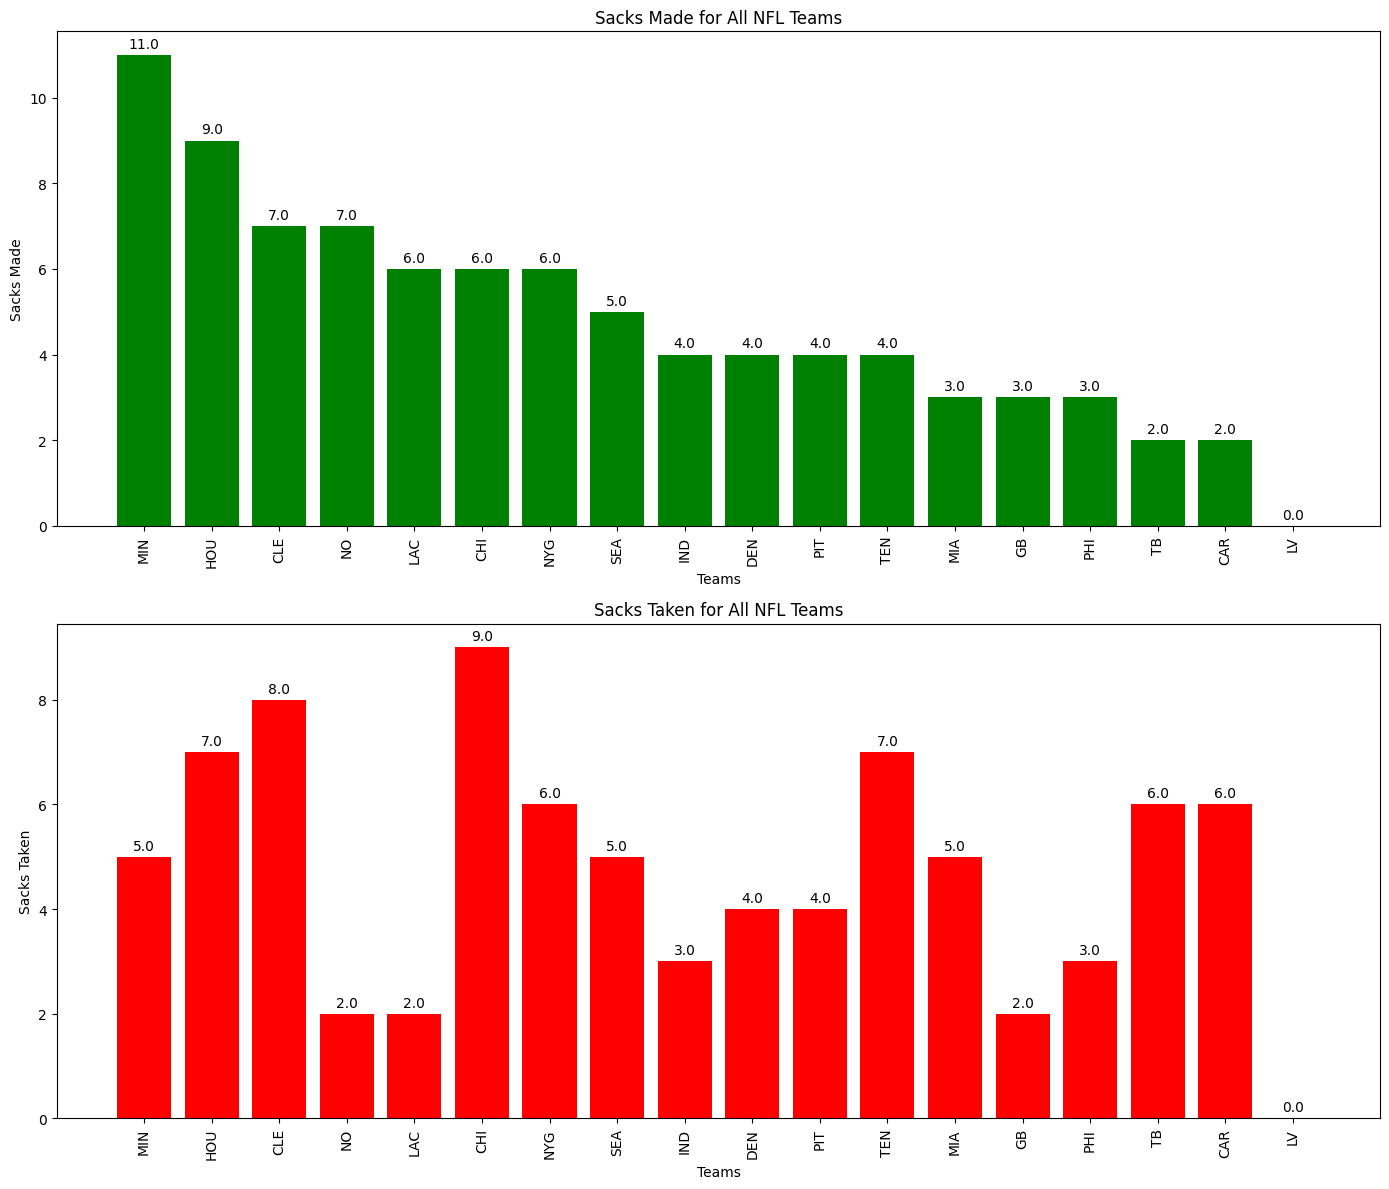

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get the list of teams from the unique team values in your dataset
teams = sacks_made_2024_filtered['team'].tolist()

# Ensure we match the correct sacks made and sacks taken for each team
sacks_made = [sacks_made_2024_filtered[sacks_made_2024_filtered['team'] == team]['sacks_made'].values[0] for team in teams]
sacks_taken = [sacks_taken_2024_filtered[sacks_taken_2024_filtered['team'] == team]['sacks_taken'].values[0] for team in teams]

# Create the x locations for the teams
x = np.arange(len(teams))  # Label locations

# Create two subplots: one for sacks made and one for sacks taken
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Bar chart for sacks made
rects1 = ax1.bar(x, sacks_made, color='green')
ax1.set_xlabel('Teams')
ax1.set_ylabel('Sacks Made')
ax1.set_title('Sacks Made for All NFL Teams')
ax1.set_xticks(x)
ax1.set_xticklabels(teams, rotation=90)  # Rotate team labels for better visibility

# Bar chart for sacks taken
rects2 = ax2.bar(x, sacks_taken, color='red')
ax2.set_xlabel('Teams')
ax2.set_ylabel('Sacks Taken')
ax2.set_title('Sacks Taken for All NFL Teams')
ax2.set_xticks(x)
ax2.set_xticklabels(teams, rotation=90)

# Add value labels on top of the bars
def autolabel(rects, ax):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add value labels to both bar charts
autolabel(rects1, ax1)
autolabel(rects2, ax2)

# Ensure layout fits well with rotated labels
plt.tight_layout()
plt.show()


### Offense <a id="offense"></a>

### 1H vs 2H <a id="offense"></a>

NFL Teams Ranked by 1st Half Scoring (2023 Season):


,Team,1st_half_points
8,Dallas Cowboys,16.833333
19,Miami Dolphins,16.166667
10,Detroit Lions,15.250000
2,Baltimore Ravens,14.631579
27,San Francisco 49ers,14.550000
3,Buffalo Bills,14.210526
15,Kansas City Chiefs,13.904762
7,Cleveland Browns,12.611111
13,Indianapolis Colts,12.588235
18,Los Angeles Rams,12.222222



NFL Teams Ranked by 2nd Half Scoring (2023 Season):


,Team,2nd_half_points
27,San Francisco 49ers,13.850000
8,Dallas Cowboys,13.222222
11,Green Bay Packers,13.157895
2,Baltimore Ravens,12.789474
22,New Orleans Saints,12.764706
25,Philadelphia Eagles,12.388889
14,Jacksonville Jaguars,12.352941
3,Buffalo Bills,12.263158
10,Detroit Lions,12.100000
19,Miami Dolphins,11.777778





NFL Teams Ranked by 1st Half Scoring (2024 Season):


,Team,1st_half_points
3,Buffalo Bills,22.666667
22,New Orleans Saints,22.666667
0,Arizona Cardinals,17.000000
11,Green Bay Packers,16.333333
28,Seattle Seahawks,14.333333
8,Dallas Cowboys,14.000000
20,Minnesota Vikings,13.666667
2,Baltimore Ravens,13.333333
27,San Francisco 49ers,12.333333
31,Washington Commanders,12.333333



NFL Teams Ranked by 2nd Half Scoring (2024 Season):


,Team,2nd_half_points
25,Philadelphia Eagles,15.333333
13,Indianapolis Colts,14.666667
3,Buffalo Bills,14.666667
20,Minnesota Vikings,14.666667
18,Los Angeles Rams,14.666667
31,Washington Commanders,14.000000
5,Chicago Bears,13.333333
24,New York Jets,13.000000
6,Cincinnati Bengals,13.000000
15,Kansas City Chiefs,13.000000


1st Half Comparison (2023 vs 2024):
                     Team  1st_half_points_2023  1st_half_points_2024
0       Arizona Cardinals             10.352941             17.000000
1         Atlanta Falcons              8.941176             10.000000
2        Baltimore Ravens             14.631579             13.333333
3           Buffalo Bills             14.210526             22.666667
4       Carolina Panthers              6.117647              8.000000
5           Chicago Bears             11.294118              4.333333
6      Cincinnati Bengals             10.647059              9.666667
7        Cleveland Browns             12.611111              7.666667
8          Dallas Cowboys             16.833333             14.000000
9          Denver Broncos              9.882353             11.000000
10          Detroit Lions             15.250000             12.000000
11      Green Bay Packers             10.631579             16.333333
12         Houston Texans             11.631579       

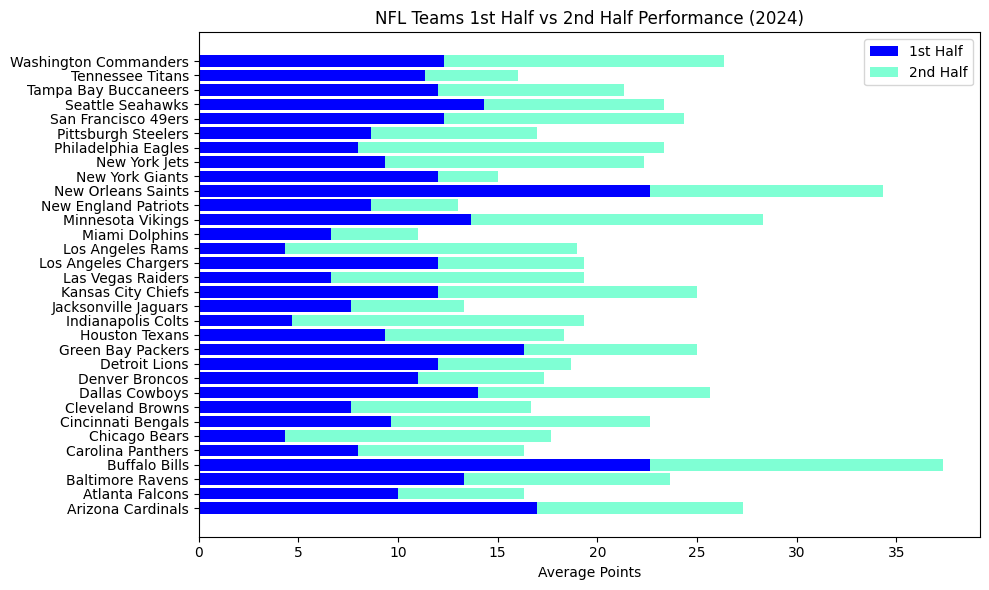

In [24]:
# 1H vs 2H points scored 2023 & 2024

nfl_data = pd.read_csv('data/box_scores.csv')

nfl_data['Season'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{4})')
nfl_data['Season'] = nfl_data['Season'].astype(int)

# Extract the year and the month from the URL using regex
nfl_data['GameDate'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{8})')
nfl_data['Year'] = nfl_data['GameDate'].str[:4].astype(int)
nfl_data['Month'] = nfl_data['GameDate'].str[4:6].astype(int)

# Correct for games played in January, February, and March
nfl_data['Season'] = nfl_data.apply(lambda row: row['Year'] - 1 if row['Month'] in [1, 2, 3] else row['Year'], axis=1)

nfl_data_2023 = nfl_data[nfl_data['Season'] == 2023].copy()

nfl_data_2023.loc[:, '1st_half_points'] = nfl_data_2023['1'] + nfl_data_2023['2']
nfl_data_2023.loc[:, '2nd_half_points'] = nfl_data_2023['3'] + nfl_data_2023['4']

team_performance_2023 = nfl_data_2023.groupby('Team').agg({
    '1st_half_points': 'mean',
    '2nd_half_points': 'mean',
    'Final': 'mean'
}).reset_index()

first_half_scoring_2023 = team_performance_2023.sort_values(by='1st_half_points', ascending=False)
second_half_scoring_2023 = team_performance_2023.sort_values(by='2nd_half_points', ascending=False)

print("NFL Teams Ranked by 1st Half Scoring (2023 Season):")
display(first_half_scoring_2023[['Team', '1st_half_points']])
print("\nNFL Teams Ranked by 2nd Half Scoring (2023 Season):")
display(second_half_scoring_2023[['Team', '2nd_half_points']])
print('\n\n')

nfl_data = pd.read_csv('data/box_scores.csv')

nfl_data['Season'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{4})')
nfl_data['Season'] = nfl_data['Season'].astype(int)

# Extract the year and the month from the URL using regex
nfl_data['GameDate'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{8})')
nfl_data['Year'] = nfl_data['GameDate'].str[:4].astype(int)
nfl_data['Month'] = nfl_data['GameDate'].str[4:6].astype(int)

# Correct for games played in January, February, and March
nfl_data['Season'] = nfl_data.apply(lambda row: row['Year'] - 1 if row['Month'] in [1, 2, 3] else row['Year'], axis=1)

nfl_data_2024 = nfl_data[nfl_data['Season'] == 2024].copy()

nfl_data_2024.loc[:, '1st_half_points'] = nfl_data_2024['1'] + nfl_data_2024['2']
nfl_data_2024.loc[:, '2nd_half_points'] = nfl_data_2024['3'] + nfl_data_2024['4']

team_performance_2024 = nfl_data_2024.groupby('Team').agg({
    '1st_half_points': 'mean',
    '2nd_half_points': 'mean',
    'Final': 'mean'
}).reset_index()

first_half_scoring_2024 = team_performance_2024.sort_values(by='1st_half_points', ascending=False)
second_half_scoring_2024 = team_performance_2024.sort_values(by='2nd_half_points', ascending=False)

print("NFL Teams Ranked by 1st Half Scoring (2024 Season):")
display(first_half_scoring_2024[['Team', '1st_half_points']])

print("\nNFL Teams Ranked by 2nd Half Scoring (2024 Season):")
display(second_half_scoring_2024[['Team', '2nd_half_points']])

# Compare the 1st half and 2nd half scoring for both seasons
comparison_1st_half = pd.merge(team_performance_2023[['Team', '1st_half_points']], 
                               team_performance_2024[['Team', '1st_half_points']], 
                               on='Team', suffixes=('_2023', '_2024'))

comparison_2nd_half = pd.merge(team_performance_2023[['Team', '2nd_half_points']], 
                               team_performance_2024[['Team', '2nd_half_points']], 
                               on='Team', suffixes=('_2023', '_2024'))

# Display the results
print("1st Half Comparison (2023 vs 2024):")
print(comparison_1st_half)
print("\n2nd Half Comparison (2023 vs 2024):")
print(comparison_2nd_half)
print('\n\n')

# Create the bar chart for the 2024 season
plt.figure(figsize=(10, 6))
plt.barh(team_performance_2024['Team'], team_performance_2024['1st_half_points'], color='blue', label='1st Half')
plt.barh(team_performance_2024['Team'], team_performance_2024['2nd_half_points'], 
         left=team_performance_2024['1st_half_points'], color='aquamarine', label='2nd Half')
plt.xlabel('Average Points')
plt.title('NFL Teams 1st Half vs 2nd Half Performance (2024)')
plt.legend()
plt.tight_layout()
plt.show()


---